In [1]:
import seaborn as sns
import matplotlib.pyplot as plt
from pyspark.sql.functions import year, month, dayofmonth
import pyspark.sql.functions as F
from pyspark.sql.functions import col, size, split, trim, when


In [2]:
# Load in one of the tables
#df.unpersist()
df1 = spark.sql("select * from default.video_games_5")
df2 = spark.sql("select * from default.books_5_small")
df3 = spark.sql("select * from default.home_and_kitchen_5_small")
df = df1.union(df2).union(df3)
#df = df.sample(False, 0.1, seed=47)
df.cache()
print((df.count(), len(df.columns)))

(3487331, 12)

In [3]:
df.show(5)

+--------+-------+----+--------+-----------+--------------+----------+-----------------+--------------------+--------------------+--------------+-----+
reviewID|overall|vote|verified| reviewTime| reviewerID| asin| reviewerName| reviewText| summary|unixReviewTime|label|
+--------+-------+----+--------+-----------+--------------+----------+-----------------+--------------------+--------------------+--------------+-----+
 0| 5.0| 0| true|10 17, 2015|A1HP7NVNPFMA4N|0700026657| Ambrosia075|This game is a bi...|but when you do i...| 1445040000| 0|
 1| 4.0| 0| false|07 27, 2015|A1JGAP0185YJI6|0700026657| travis|I played it a whi...|But in spite of t...| 1437955200| 0|
 2| 3.0| 0| true|02 23, 2015|A1YJWEXHQBWK2B|0700026657|Vincent G. Mezera| ok game.| Three Stars| 1424649600| 0|
 3| 2.0| 0| true|02 20, 2015|A2204E1TH211HT|0700026657| Grandma KR|found the game a ...| Two Stars| 1424390400| 0|
 4| 5.0| 0| true|12 25, 2014|A2RF5B5H74JLPE|0700026657| jon|great game, I lov...| love this game| 1419465600| 0|
+--------+-------+----+--------+-----------+--------------+----------+-----------------+--------------------+--------------------+--------------+-----+
only showing top 5 rows

In [4]:
# Convert Unix timestamp to readable date

from pyspark.sql.functions import from_unixtime, to_date

df = df.withColumn("reviewTime", to_date(from_unixtime(df.unixReviewTime))) \
                                                .drop("unixReviewTime")

lastDate = df.agg({"reviewTime": "max"}).collect()[0][0]
from pyspark.sql.functions import lit

df = df.withColumn('lastDate',lit(lastDate))
#https://stackoverflow.com/questions/42260961/calculate-time-between-two-dates-in-pyspark
df = df.withColumn('reviewAge', F.datediff('lastDate', 'reviewTime'))
df = df.withColumn('reviewYear', year('ReviewTime'))

In [5]:
display(df.select('reviewYear').groupBy('reviewYear').count().orderBy('ReviewYear', ascending=True))

reviewYear,count
1996,3
1997,403
1998,1722
1999,2935
2000,14043
2001,18143
2002,21396
2003,21770
2004,24609
2005,32310


In [6]:
display(df.select('reviewYear','label').groupBy('reviewYear','label').count().orderBy('ReviewYear', ascending=True))

reviewYear,label,count
1996,1,3
1997,0,236
1997,1,167
1998,0,1003
1998,1,719
1999,0,1057
1999,1,1878
2000,1,10030
2000,0,4013
2001,0,6541


In [7]:
ratings = df.select("overall","label").groupBy("overall","label").count()

In [8]:
display(ratings)

overall,label,count
2.0,1,50308
1.0,0,100616
2.0,0,102702
4.0,0,499004
4.0,1,113571
5.0,0,1937504
3.0,1,70282
1.0,1,78430
5.0,1,313575
3.0,0,221339


In [9]:
verified = df.select("verified","label").groupBy("verified","label").count()

In [10]:
display(verified)

verified,label,count
true,0,2461122
true,1,370545
false,0,400043
false,1,255621


In [11]:
test_df = spark.sql("select * from default.reviews_kaggle")

In [12]:
# Convert Unix timestamp to readable date

from pyspark.sql.functions import from_unixtime, to_date

test_df = test_df.withColumn("reviewTime", to_date(from_unixtime(test_df.unixReviewTime))) \
                                                .drop("unixReviewTime")

In [13]:
test_df = test_df.withColumn('reviewYear', year('ReviewTime'))

In [14]:
training_years = df.select('reviewYear').groupBy('reviewYear').count().orderBy('ReviewYear', ascending=True).toPandas()

In [15]:
test_years = test_df.select('reviewYear').groupBy('reviewYear').count().orderBy('ReviewYear', ascending=True).toPandas()

In [16]:
display(training_years.merge(test_years, how='left', on='reviewYear').fillna(0).rename(columns={"count_x": "Training Instances", "count_y": "Test Instances"}))

reviewYear,Training Instances,Test Instances
1996,3,0.0
1997,403,1.0
1998,1722,6.0
1999,2935,47.0
2000,14043,136.0
2001,18143,207.0
2002,21396,380.0
2003,21770,626.0
2004,24609,299.0
2005,32310,546.0


In [17]:
review_age = df.select("reviewAge","label").toPandas()

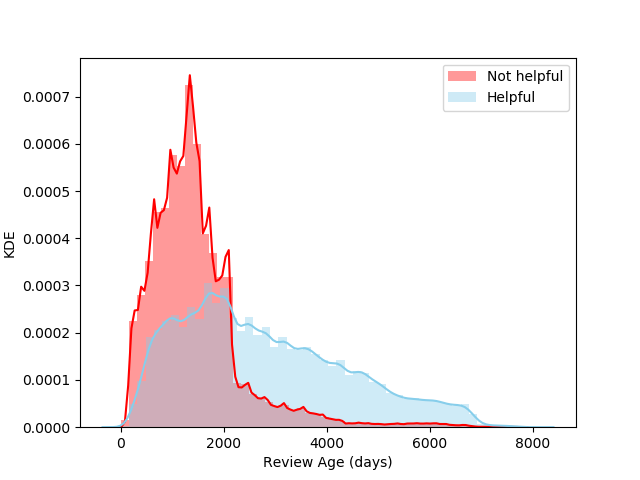

In [18]:
#https://python-graph-gallery.com/25-histogram-with-several-variables-seaborn/
fig, ax = plt.subplots()
sns.distplot(review_age[review_age['label']==0]['reviewAge'], color="red", label="Not helpful")
sns.distplot(review_age[review_age['label']==1]['reviewAge'], color="skyblue", label = "Helpful")
ax.legend()
ax.set(xlabel='Review Age (days)', ylabel='KDE')
display(fig)

In [19]:
#dF.withColumn('body_len', F.length(trim(col('reviewText')))).show()
#https://stackoverflow.com/questions/51450004/spark-dataframe-python-count-substring-in-string
#There are some cases where there are more spaces than characters. These give negative numbers. We will replace with 0
df = df.withColumn('word_count', F.size(F.split(F.col('reviewText'), ' ')))
df = df.withColumn('character_count',  when((F.length(trim(col('reviewText'))) - size(split(trim(col("reviewText")), " ")) - 1)<0,0).otherwise(F.length(trim(col('reviewText'))) - size(split(trim(col("reviewText")), " ")) - 1))
df = df.withColumn('sentence_count', F.size(F.split(F.col('reviewText'), r"\.")))
df = df.withColumn('avg_word_length', F.col('character_count')/F.col('word_count'))
df = df.withColumn('avg_sentence_length', F.col('word_count')/F.col('sentence_count'))

In [20]:
word_counts = df.select("word_count",'character_count','sentence_count','avg_word_length','avg_sentence_length',"label").toPandas()

In [21]:
sns.__version__

Out[21]: '0.8.1'

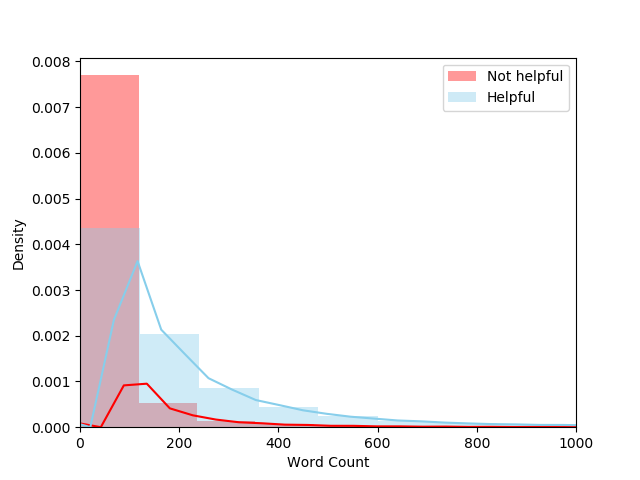

In [22]:
fig, ax = plt.subplots()
sns.distplot(word_counts[word_counts['label']==0]['word_count'], color="red", label="Not helpful", hist=True)
sns.distplot(word_counts[word_counts['label']==1]['word_count'], color="skyblue", label = "Helpful", hist=True)
ax.legend()
plt.xlim(0, 1000)
ax.set(xlabel='Word Count', ylabel='Density')
display(fig)

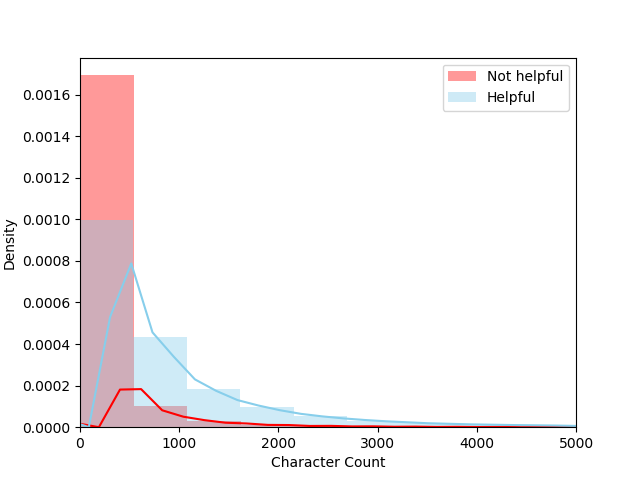

In [23]:
fig, ax = plt.subplots()
sns.distplot(word_counts[word_counts['label']==0]['character_count'], color="red", label="Not helpful")
sns.distplot(word_counts[word_counts['label']==1]['character_count'], color="skyblue", label = "Helpful")
ax.legend()
plt.xlim(0, 5000)
ax.set(xlabel='Character Count', ylabel='Density')
display(fig)

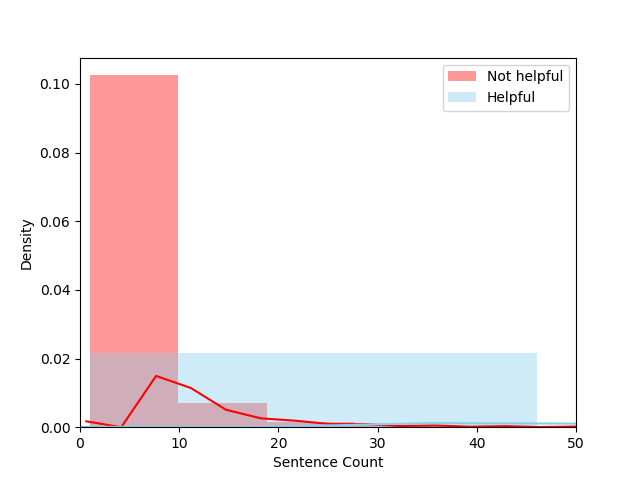

In [24]:
#Not used
fig, ax = plt.subplots()
sns.distplot(word_counts[word_counts['label']==0]['sentence_count'], color="red", label="Not helpful")
sns.distplot(word_counts[word_counts['label']==1]['sentence_count'], color="skyblue", label = "Helpful")
ax.legend()
plt.xlim(0, 50)
ax.set(xlabel='Sentence Count', ylabel='Density')
display(fig)

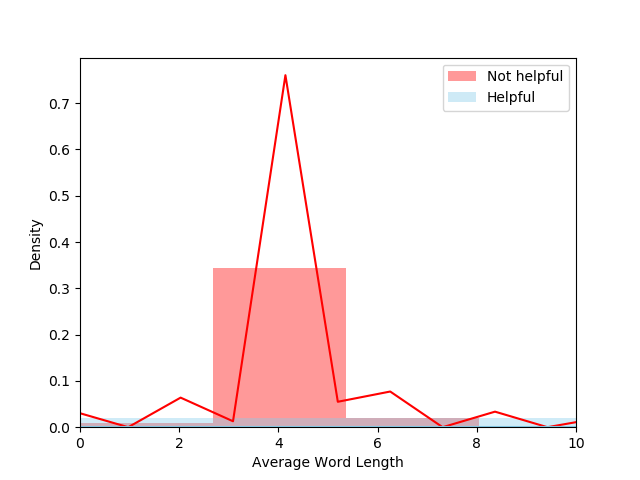

In [25]:
#Not used
fig, ax = plt.subplots()
sns.distplot(word_counts[word_counts['label']==0]['avg_word_length'], color="red", label="Not helpful")
sns.distplot(word_counts[word_counts['label']==1]['avg_word_length'], color="skyblue", label = "Helpful")
ax.legend()
plt.xlim(0, 10)
ax.set(xlabel='Average Word Length', ylabel='Density')
display(fig)

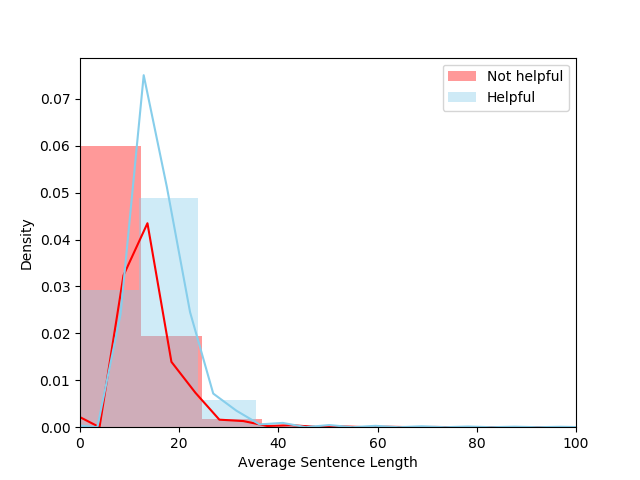

In [26]:
fig, ax = plt.subplots()
sns.distplot(word_counts[word_counts['label']==0]['avg_sentence_length'], color="red", label="Not helpful")
sns.distplot(word_counts[word_counts['label']==1]['avg_sentence_length'], color="skyblue", label = "Helpful")
plt.xlim(0, 100)
ax.set(xlabel='Average Sentence Length', ylabel='Density')
ax.legend()
display(fig)

In [27]:
from textblob import TextBlob
def sentiment_score(chat):
  try:
    return TextBlob(chat).sentiment.polarity
  except:
    return None
  
from pyspark.sql.types import FloatType
sentiment_score_udf = F.udf(lambda x: sentiment_score(x), FloatType())

In [28]:
df = df.withColumn('sentiment_score',sentiment_score_udf('reviewText'))

In [29]:
sentiments = df.select('sentiment_score',"label").toPandas()

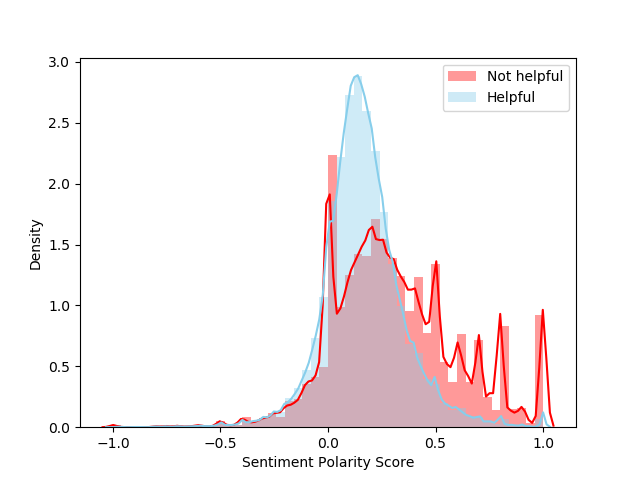

In [30]:
fig, ax = plt.subplots()
sns.distplot(sentiments[sentiments['label']==0]['sentiment_score'], color="red", label="Not helpful")
sns.distplot(sentiments[sentiments['label']==1]['sentiment_score'], color="skyblue", label = "Helpful")
ax.set(xlabel='Sentiment Polarity Score', ylabel='Density')
ax.legend()
display(fig)

In [31]:
df = df.withColumn('sum_word_count', F.size(F.split(F.col('summary'), ' ')))
df = df.withColumn('sum_character_count',  when((F.length(trim(col('summary'))) - size(split(trim(col("summary")), " ")) - 1)<0,0).otherwise(F.length(trim(col('summary'))) - size(split(trim(col("summary")), " ")) - 1))
df = df.fillna(0, subset=['sum_character_count'])
df = df.withColumn('sum_sentence_count', F.size(F.split(F.col('summary'), r"\.")))
df = df.withColumn('sum_avg_word_length', F.col('sum_character_count')/F.col('sum_word_count'))
df = df.withColumn('sum_avg_sentence_length', F.col('sum_word_count')/F.col('sum_sentence_count'))

In [32]:
sum_word_counts = df.select("sum_word_count",'sum_character_count','sum_sentence_count','sum_avg_word_length','sum_avg_sentence_length',"label").toPandas()

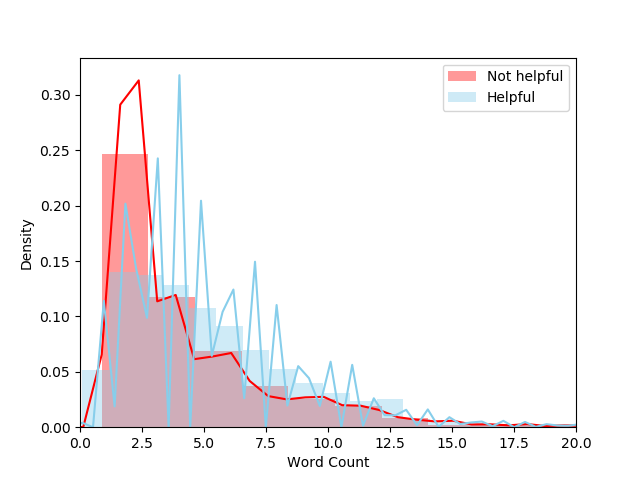

In [33]:
fig, ax = plt.subplots()
sns.distplot(sum_word_counts[sum_word_counts['label']==0]['sum_word_count'], color="red", label="Not helpful")
sns.distplot(sum_word_counts[sum_word_counts['label']==1]['sum_word_count'], color="skyblue", label = "Helpful")
ax.legend()
ax.set(xlabel='Word Count', ylabel='Density')
plt.xlim(0, 20)
display(fig)

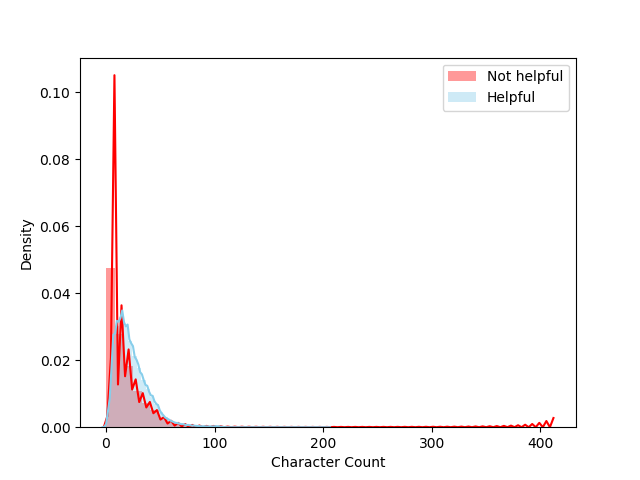

In [34]:
fig, ax = plt.subplots()
sns.distplot(sum_word_counts[sum_word_counts['label']==0]['sum_character_count'], color="red", label="Not helpful")
sns.distplot(sum_word_counts[sum_word_counts['label']==1]['sum_character_count'], color="skyblue", label = "Helpful")
ax.legend()
ax.set(xlabel='Character Count', ylabel='Density')
#plt.xlim(0, 1000)
display(fig)

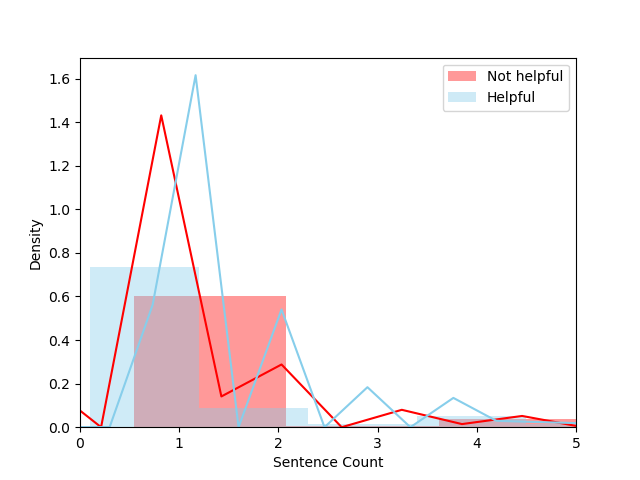

In [35]:
fig, ax = plt.subplots()
sns.distplot(sum_word_counts[sum_word_counts['label']==0]['sum_sentence_count'], color="red", label="Not helpful")
sns.distplot(sum_word_counts[sum_word_counts['label']==1]['sum_sentence_count'], color="skyblue", label = "Helpful")
ax.legend()
ax.set(xlabel='Sentence Count', ylabel='Density')
plt.xlim(0, 5)
display(fig)

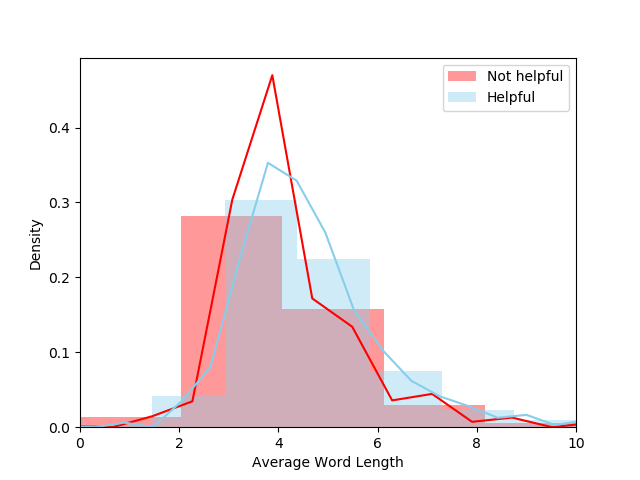

In [36]:
#Not used
fig, ax = plt.subplots()
sns.distplot(sum_word_counts[sum_word_counts['label']==0]['sum_avg_word_length'], color="red", label="Not helpful")
sns.distplot(sum_word_counts[sum_word_counts['label']==1]['sum_avg_word_length'], color="skyblue", label = "Helpful")
ax.legend()
plt.xlim(0, 10)
ax.set(xlabel='Average Word Length', ylabel='Density')
display(fig)

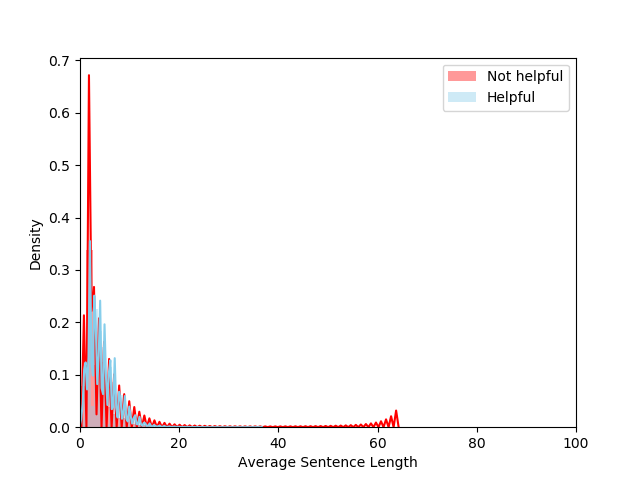

In [37]:
#Not used
fig, ax = plt.subplots()
sns.distplot(sum_word_counts[sum_word_counts['label']==0]['sum_avg_sentence_length'], color="red", label="Not helpful")
sns.distplot(sum_word_counts[sum_word_counts['label']==1]['sum_avg_sentence_length'], color="skyblue", label = "Helpful")
ax.legend()
ax.set(xlabel='Average Sentence Length', ylabel='Density')
plt.xlim(0, 100)
display(fig)

In [38]:
df = df.withColumn('sentiment_score_sum',sentiment_score_udf('summary'))

In [39]:
sentiments_sum = df.select('sentiment_score_sum',"label").fillna({'sentiment_score_sum':'0'}).toPandas()

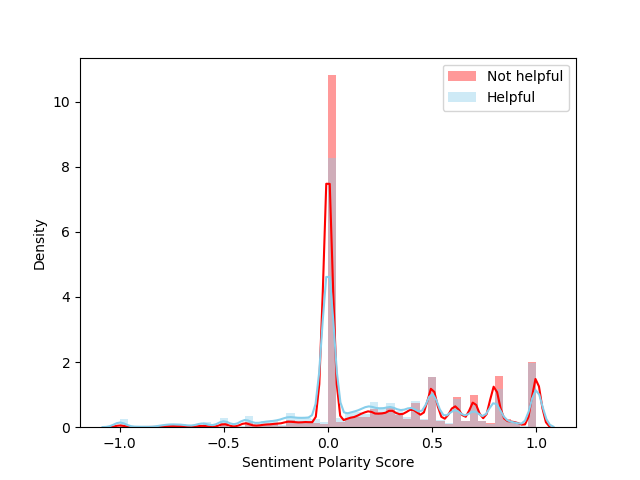

In [40]:
fig, ax = plt.subplots()
sns.distplot(sentiments_sum[sentiments_sum['label']==0]['sentiment_score_sum'], color="red", label="Not helpful")
sns.distplot(sentiments_sum[sentiments_sum['label']==1]['sentiment_score_sum'], color="skyblue", label = "Helpful")
ax.set(xlabel='Sentiment Polarity Score', ylabel='Density')
ax.legend()
display(fig)

In [41]:
top_10 = (df.select('reviewerID').groupBy('reviewerID').count().orderBy('count', ascending=False)).limit(10)

In [42]:
top_10_df = df.join(top_10, on=['reviewerID'], how='inner')

In [43]:
display(top_10_df)

reviewerID reviewID overall vote verified reviewTime asin reviewerName reviewText summary unixReviewTime label word_count character_count sentence_count avg_word_length avg_sentence_length sentiment_score count A29BQ6B90Y1R5F 92 4.0 11 true 11 27, 2013 0804161380 Tsanche In recent memory, strategy guides have become less of a necessity and more of a collector's item. For every game nowadays there is a guide to accompany it. Sometimes there's a collector's edition guide as well. For collector's these are sometimes a lot of fun. For Zelda fans that enjoy Zelda lore this collection is a fantastic buy. There is a limited number in print and it's simply amazing to behold. It's great packaging and actually has things in there specifically for collectors. Before I begin I want to stress that this review won't be going into the content of each guide. With the exception of the Skyward Sword guide, each of these guides is exactly the same as their standard (and separately released) collector's edition counterpart. The reason Skyward Sword is not the same is because this copy was revised and expanded upon. Aside from that, the other five guides are largely unchanged from their original releases. There are subtle differences but nothing that greatly changes the actual content in the guide. To begin, the guides come packaged in a box that looks like a chest. When you open it up there are six hardbound guides in there. The covers all look very similar. Each one having an embossed Hyrule symbol on them. The covers and the borders are different on each guide. The six guides included are for Twilight Princess, Phantom Hourglass, Spirit Tracks, Ocarina of Time 3D, Skyward Sword and the Windwaker HD. All the guides have gold leaf pages that are shiny when looking at them from the side. There are a couple of things to note about the guides themselves. The first is that it seems just a little strange that the guides themselves are not actually individually shrink wrapped. This seems a little odd. It's not that big of a deal but when you open the packaging they're already loose. Considering each original release came shrink wrapped it's a little strange. Perhaps the thing that some consumers might mind is that none of these guides come with their respective extras. Anything that was considered a bonus for getting the collector's edition guide isn't here. Likewise, when this particular collection was announced, The Legend of Zelda: A Link Between Worlds simply wasn't planned for the package. So anyone hoping this guide comes with the collection are out of luck. That's no big deal. There are also a couple of things to note here about only a couple of guides. The first and most obvious is the Ocarina of Time 3D guide. Prima NEVER actually released a hardcover edition of this guide. Ever. This is the first time that Ocarina of Time 3D players will get to grab this guide in hardcover. Originally the guide was only in paperback. This makes the collector's value certainly worthwhile as it means that the guide will have much more limited hardcover run than all the other guides here. This boxset is more or less your only chance to get it. The second thing of note is that the Skyward Sword guide included here is NOT the same as the one originally published. It has been revised and expanded. Even the layout is very different from the original guide itself. It has been revised and expanded by over 100 pages. It is almost a completely new guide from the original one that was released. So yes, this one too is a rarity because you won't have much luck finding it outside of this particular box set. There are a couple of subtle differences between some guides and the originals. Most notably is the Ocarina of Time 3D guide. The original guide was around 224 pages and written in three columns. Here it's 288 pages and is written in two columns. It's a lot easier to read and a lot cleaner as a result. Much of the text isn't so cramped. Some moments in the Ocarina of Ti

In [44]:
display(df.select('label','word_count','sentiment_score', 'overall').agg({'label': 'avg', 'word_count': 'avg','sentiment_score': 'avg', 'overall': 'avg'}))

avg(sentiment_score),avg(word_count),avg(overall),avg(label)
0.2816818727940823,75.93244633216635,4.320101533235589,0.1795545074442317


In [45]:
reviewer_type_df = df.select('reviewerID').groupBy('reviewerID').count().orderBy('count', ascending=False)
reviewer_type_df = reviewer_type_df.withColumn("reviewType", when(col('count')>=20, "Top Reviewer").otherwise("Other"))
df = df.join(reviewer_type_df, on=['reviewerID'], how='inner')

In [46]:
reviewTypeHabits = df.select('word_count','sentiment_score','reviewType').toPandas()

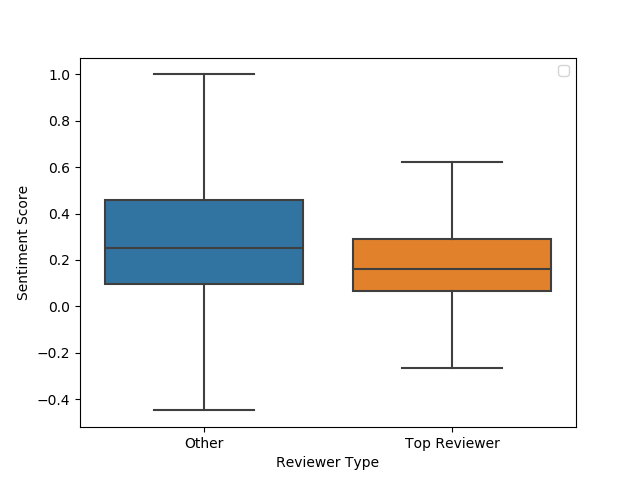

In [47]:
fig, ax = plt.subplots()
sns.boxplot(x='reviewType', y="sentiment_score", data=reviewTypeHabits, showfliers = False)
ax.legend()
ax.set(xlabel='Reviewer Type', ylabel='Sentiment Score')
display(fig)

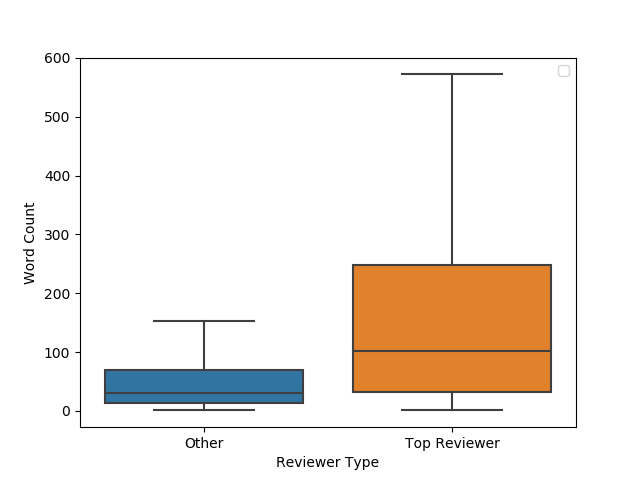

In [48]:
fig, ax = plt.subplots()
sns.boxplot(x='reviewType', y="word_count", data=reviewTypeHabits, showfliers = False)
ax.legend()
ax.set(xlabel='Reviewer Type', ylabel='Word Count')
display(fig)

In [49]:
helpful_df = (df.filter(df.label==1).select('reviewerID','reviewType').groupBy('reviewerID','reviewType').count().orderBy('count', ascending=False))
helpful_df = helpful_df.drop('reviewType')
total_df = (df.select('reviewerID','reviewType').groupBy('reviewerID','reviewType').count().orderBy('count', ascending=False))
total_df = total_df.withColumnRenamed('count', 'total')
percent_helpful_df = total_df.join(helpful_df, on=['reviewerID'], how='left').na.fill(0)
percent_helpful_df = percent_helpful_df.withColumn("percent_helpful", col('count')/col('total'))

In [50]:
percent_helpful_df = percent_helpful_df.toPandas()

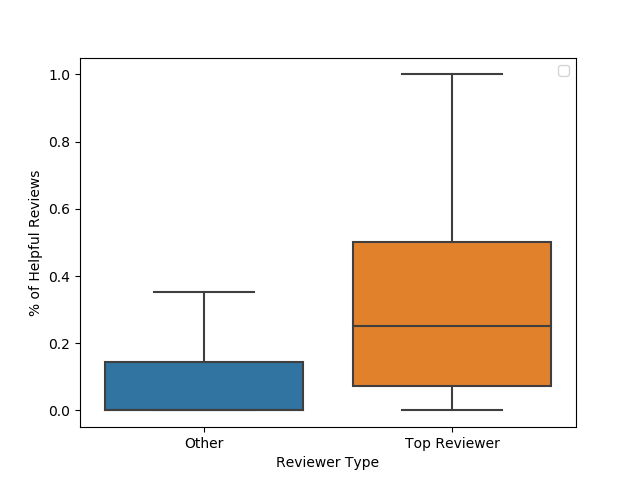

In [51]:
fig, ax = plt.subplots()
sns.boxplot(x='reviewType', y='percent_helpful', data=percent_helpful_df, showfliers = False)
ax.legend()
ax.set(xlabel='Reviewer Type', ylabel='% of Helpful Reviews')
display(fig)